# Netflix Dataset

In [ ]:
!pip install apache_beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.3/671.3 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 84.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 39.6 M

# Composite Transform and Pipeline with Windowed Triggers
## Top 5 Most Watched Titles

Minnal Murali: 37
"Demon Slayer: Kimetsu no Yaiba: Tanjiro Kamado: 37
Red Notice: 21
Jana Gana Mana: 19
Don't Look Up: 19


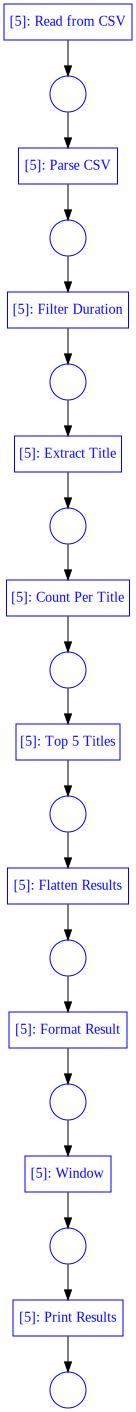

In [ ]:
from apache_beam.transforms.trigger import AfterProcessingTime
import apache_beam as beam
from apache_beam.runners.interactive.display import pipeline_graph
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.transforms.combiners import Top
from apache_beam.transforms.window import FixedWindows
import graphviz

def parse_csv(element):
    fields = element.split(",")
    return {
        "Profile Name": fields[0],
        "Start Time": fields[1],
        "Duration": fields[2],
        "Title": fields[4]
    }

def filter_duration(element):
    duration = element["Duration"].split(":")
    minutes = int(duration[1])
    seconds = int(duration[2])
    return minutes > 1 or (minutes == 1 and seconds > 0)

def get_title(element):
    return element["Title"], 1

def format_result(title_count):
    (title, count) = title_count
    return f"{title}: {count}"

def display_graph(pipeline):
  graph = pipeline_graph.PipelineGraph(pipeline)
  display(graphviz.Source(graph.get_dot()))


options = PipelineOptions()
with beam.Pipeline(options=options) as p:
  (
    p | "Read from CSV" >> beam.io.ReadFromText("All_ViewingActivity.csv", skip_header_lines=1)
      | "Parse CSV" >> beam.Map(parse_csv)
      | "Filter Duration" >> beam.Filter(filter_duration)
      | "Extract Title" >> beam.Map(get_title)
      | "Count Per Title" >> beam.CombinePerKey(sum)
      | "Top 5 Titles" >> Top.Of(5, key=lambda x: x[1])
      | "Flatten Results" >> beam.FlatMap(lambda x: x)
      | "Format Result" >> beam.Map(format_result)
      | "Window" >> beam.WindowInto(
        FixedWindows(3600),
        trigger=AfterProcessingTime(600),  # Fire every 10 minutes (6 times per hour)
        accumulation_mode=beam.transforms.trigger.AccumulationMode.ACCUMULATING)
      | "Print Results" >> beam.Map(print)
  )

display_graph(p)

# Composite Transform and Pipeline using ParDo
## Count views per year month

04-2022: 901 views
01-2022: 637 views
12-2021: 487 views
11-2022: 397 views
09-2022: 250 views
08-2022: 643 views
07-2022: 443 views
05-2022: 420 views
11-2021: 129 views
06-2022: 958 views
03-2022: 686 views
02-2022: 926 views
10-2021: 6 views
10-2022: 301 views
06-2023: 281 views
05-2023: 558 views
04-2023: 485 views
03-2023: 335 views
02-2023: 440 views
01-2023: 523 views
12-2022: 186 views


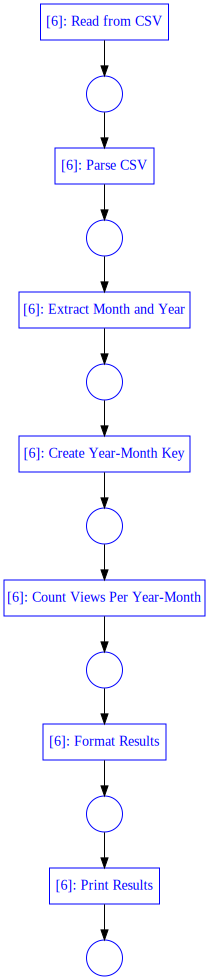

In [ ]:
from apache_beam import DoFn, PTransform, ParDo, Map, CombinePerKey
from apache_beam.io import ReadFromText
from apache_beam.options.pipeline_options import PipelineOptions

class ExtractMonthYearFn(DoFn):
    def process(self, element):
        date_parts = element["Start Time"].split("-")
        year, month = date_parts[0], date_parts[1]
        element["Year"] = year
        element["Month"] = month
        return [element]

class FormatCountsFn(DoFn):
    def process(self, element):
        year_month, count = element
        year, month = year_month
        return [f"{month}-{year}: {count} views"]

with beam.Pipeline(options=PipelineOptions()) as p:
    (
        p
        | "Read from CSV" >> ReadFromText("All_ViewingActivity.csv", skip_header_lines=1)
        | "Parse CSV" >> Map(parse_csv)  # Assuming parse_csv is the function you have for parsing
        | "Extract Month and Year" >> ParDo(ExtractMonthYearFn())
        | "Create Year-Month Key" >> Map(lambda x: ((x["Year"], x["Month"]), 1))
        | "Count Views Per Year-Month" >> CombinePerKey(sum)
        | "Format Results" >> ParDo(FormatCountsFn())
        | "Print Results" >> Map(print)
    )

display_graph(p)